## 보스턴 주택 데이터셋 로드하기

In [2]:
from keras.datasets import boston_housing

In [7]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [8]:
print(train_data[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


- CRIM 자치시(town) 별 1인당 범죄율
- ZN 25,000 평방피트를 초과하는 거주지역의 비율
- INDUS 비소매상업지역이 점유하고 있는 토지의 비율
- CHAS 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX 10ppm 당 농축 일산화질소
- RM 주택 1가구당 평균 방의 개수
- AGE 1940년 이전에 건축된 소유주택의 비율
- DIS 5개의 보스턴 직업센터까지의 접근성 지수
- RAD 방사형 도로까지의 접근성 지수
- TAX 10,000 달러 당 재산세율
- PTRATIO 자치시(town)별 학생/교사 비율
- B 1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함.
- LSTAT 모집단의 하위계층의 비율(%)
- MEDV 본인 소유의 주택가격(중앙값) (단위: $1,000)

In [4]:
train_data.shape

(404, 13)

In [5]:
print(train_targets[0])

15.2


## 데이터 정규화하기

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [7]:
print(mean) # 평균

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]


In [8]:
print(std) # 표준편차

[9.22929073e+00 2.37382770e+01 6.80287253e+00 2.40939633e-01
 1.17147847e-01 7.08908627e-01 2.79060634e+01 2.02770050e+00
 8.68758849e+00 1.66168506e+02 2.19765689e+00 9.39946015e+01
 7.24556085e+00]


### 정규화된 데이터

In [9]:
print(train_data[0])

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


In [10]:
print(test_data[0])

[ 1.55369355 -0.48361547  1.0283258  -0.25683275  1.03838067  0.23545815
  1.11048828 -0.93976936  1.67588577  1.5652875   0.78447637 -3.48459553
  2.25092074]


## 모델 정의하기

In [11]:
from keras import models, layers

def build_model(): # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### 이 네트워크의 마지막 층은 하나의 유닛을 가지고 있고 활성화 함수가 없습니다. (선형 층)

이 모델은 mse(평균 제곱 오차) 손실 함수를 사용하여 컴파일합니다. 회귀 문제에서 널리 사용되는 손실 함수입니다.

훈련하는 동안 모니터링을 위해 새로운 지표인 평균 절대 오차(MAE)를 측정합니다. 이는 예측과 타깃 사이 거리의 절댓값입니다.

## k-겹 검증하기

> 데이터 포인트가 많지 않기 때문에 검증 세트도 매우 작아집니다. 검증 세트와 훈련 세트로 어떤 데이터 포인터가 선택되었는지에 따라 검증 점수가 크게 달라집니다. 데이터를 K개의 분할로 나누고, K개의 모델을 각각 만들어 K-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법입니다. (K-fold cross-validation)

In [12]:
import numpy as np

k = 4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0) # verbose=0이므로 훈련 과정이 출력되지 않습니다.
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [28]:
all_scores

[2.083195447921753, 2.457456111907959, 2.7008023262023926, 2.4599387645721436]

In [29]:
np.mean(all_scores)

2.425348162651062

## 각 폴드에서 검증 점수를 로그에 저장하기

In [24]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0) # verbose=0이므로 훈련 과정이 출력되지 않습니다.
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


## K-겹 검증 점수 평균을 기록하기

In [25]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [30]:
average_mae_history

[4.500454068183899,
 3.3091705441474915,
 3.0313526391983032,
 2.8646695613861084,
 2.7851011157035828,
 2.773279309272766,
 2.553735673427582,
 2.6105403900146484,
 2.599431812763214,
 2.578539490699768,
 2.5080872774124146,
 2.4245699644088745,
 2.5523842573165894,
 2.4009405374526978,
 2.4970709085464478,
 2.4104188680648804,
 2.4951515197753906,
 2.3940181136131287,
 2.390624463558197,
 2.4998779892921448,
 2.4207587838172913,
 2.437180459499359,
 2.3890058398246765,
 2.4005947709083557,
 2.411199003458023,
 2.44206303358078,
 2.329553872346878,
 2.4085172712802887,
 2.51782488822937,
 2.3742764592170715,
 2.502080738544464,
 2.4061766862869263,
 2.3455170392990112,
 2.3701075315475464,
 2.3383437991142273,
 2.522939294576645,
 2.391205221414566,
 2.3222638368606567,
 2.376798152923584,
 2.395145922899246,
 2.2878419160842896,
 2.3671769499778748,
 2.446380913257599,
 2.3681174218654633,
 2.3817264437675476,
 2.3877023458480835,
 2.374772697687149,
 2.3859393894672394,
 2.372521936

## 검증 점수 그래프

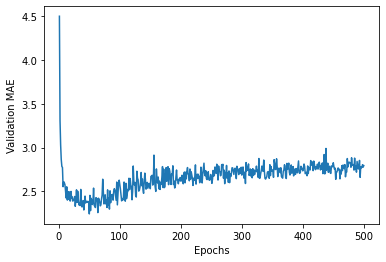

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

이 그래프는 범위가 크고 변동이 심하기 때문에 보기 어렵다.
- 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외시킨다.
- 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 **지수 이동 평균**으로 대체한다.

## 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기

In [33]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

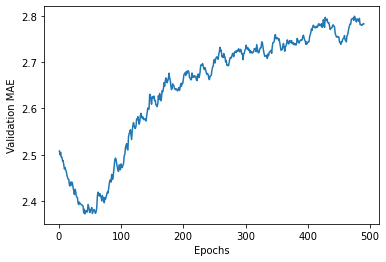

In [34]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### 80번째 에포크 이후에 줄어드는 것이 멈추었다.

## 최종 모델 훈련하기

In [37]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0) # 전체 데이터로 훈련
test_mse_socre, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 17.3823 - mae: 2.6092


In [38]:
test_mae_score

2.6091697216033936